# 🚜 Predicting the sale price of bulldozers using machine learning

In this notebook, we will go through an example of a machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem Definition

> Given its characteristics and previous examples of how much similar bulldozers have been sold for, how well can we predict the future sale prices of a bulldozer?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data 

There are three main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more details on the evaluation of this project: https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

**Note**: The goal for most regression evaluation metrics is to minimise the error. For instance, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary that details all features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/14rqD0j17Bvl2VW1ZfDirlLsTrlLpmgQqv1ZMJxOso7g/edit?usp=sharing

In [1]:
# Import tools for data analysis and transformation

# Regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For plots to appear inside the notebook
%matplotlib inline

# Data exploration

In [2]:
# Import training and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory = False)

In [3]:
# Get information on what is happening
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
# Check for missing values
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [5]:
# View the names of the columns
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

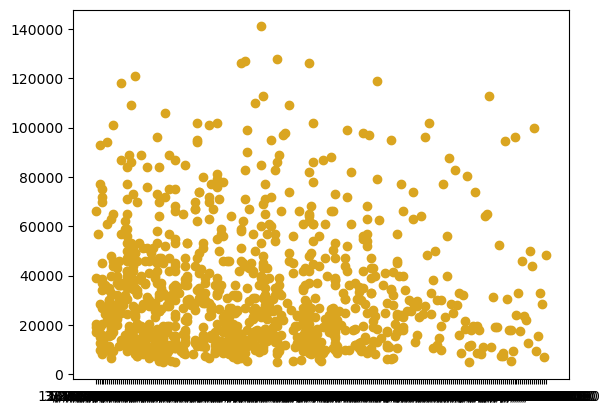

In [6]:
# Visualise the information we have using the first 1,000 examples
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000],
           c = "goldenrod");

In [7]:
df["saledate"][:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

In [8]:
df["saledate"].dtype

dtype('O')

As we have plotted a scatterplot using `saledate` as the x axis, the format of the feature has resulted in the labels becoming too cluttered and illegible.

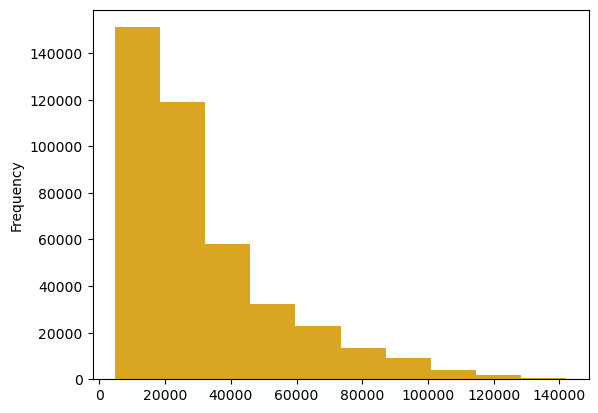

In [9]:
df["SalePrice"].plot.hist(color = "goldenrod");

A large portion of our examples are priced below USD 20,000, some are priced between USD 20,000 and USD 30,000, and the number of examples continue to deplete as the price increases. There are not many examples that cost above USD 100,000. 

# Feature engineering

### Parsing dates

When working with time series data, we would want to enrich the date and time component as much as possible.

We can do this by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [10]:
# Import data again but parse data this time around
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory = False,
                 parse_dates = ["saledate"])

In [11]:
df["saledate"][:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

In [12]:
df["saledate"].dtype

dtype('<M8[ns]')

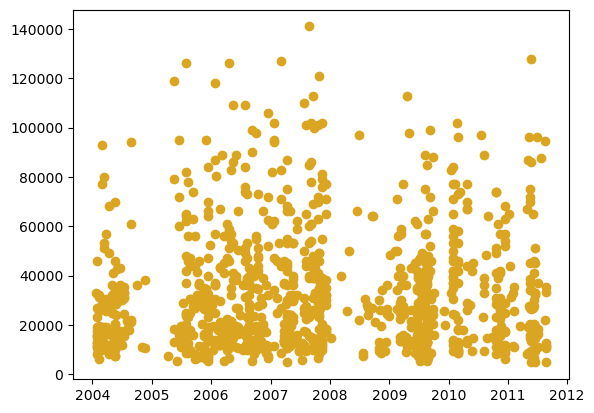

In [13]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000],
           c = "goldenrod");

Parsing the dates has converted the `saledate` feature from an object type to a datetime object type, which allows us to visualise the x axis labels in a more comprehensible way.

We see that there were not many sales transacted in 2005 and 2008, possibly due to the Hurricane Katrina disaster and Financial crisis during the respective years.

In [14]:
# Show values of all columns for the first 5 examples
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [15]:
# Show saledate for the first 20 examples
df["saledate"].head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

As it is a good idea to sort time series data by date, we will proceed to sort the DataFrame by `saledate`.

In [16]:
# Sort DataFrame in date order
df.sort_values(by = ["saledate"],
               inplace = True,
               ascending = True)

# View the first 20 examples after sorting
df["saledate"].head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We will make a copy of the original DataFrame so as to manipulate the copy and keep the original data.

In [17]:
# Make a copy of the DataFrame
df_exp = df.copy()

In [18]:
# Show values of all columns for the first 5 examples from the copied DataFrame 
df_exp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


### Add datetime parameters for `saledate` column

In [19]:
# Extract out the day, month, year, day of week, day of year, quarter
df_exp["saleYear"] = df_exp["saledate"].dt.year
df_exp["saleMonth"] = df_exp["saledate"].dt.month
df_exp["saleDay"] = df_exp["saledate"].dt.day
df_exp["saleDayOfWeek"] = df_exp["saledate"].dt.dayofweek
df_exp["saleDayOfYear"] = df_exp["saledate"].dt.dayofyear
df_exp["saleQuarter"] = df_exp["saledate"].dt.quarter

In [20]:
df_exp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


Now that we have enriched our DataFrame with date-time features, we can remove `saledate`.

In [21]:
df_exp.drop("saledate", axis = 1, inplace = True)

In [22]:
# Check the values of different columns
df_exp["state"].value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

### Convert strings to categories

To turn all of our data into numbers, we will convert them into pandas categories.

In [23]:
df_exp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [24]:
# Find columns that contain strings
for label, content in df_exp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [25]:
# DataFrame behaves like a dictionary - df.items()
random_dict = {"k1": "word",
               "k2": "play"}

for key, value in random_dict.items():
    print(f"This is a key: {key}, and this is a value: {value}")

This is a key: k1, and this is a value: word
This is a key: k2, and this is a value: play


In [26]:
# Turn all string (object) values into category values
for label, content in df_exp.items():
    if pd.api.types.is_string_dtype(content):
        df_exp[label] = content.astype("category").cat.as_ordered()

In [27]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [28]:
df_exp["state"].cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [29]:
# Access the numeric value assigned to each category in the state feature
df_exp["state"].cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas categories, we are now able to access all of our data in the form of numbers.

Next, we will handle missing data.

In [30]:
# Check missing data (ratio of examples with null values to total number of examples)
df_exp.isnull().sum() / len(df_exp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [31]:
# Check missing data
df_exp.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Save preprocessed data

Uncomment the next two blocks of code to export and import back the preprocessed data.

In [32]:
# # Export current exp dataframe
# df_exp.to_csv("data/bluebook-for-bulldozers/train_exp.csv",
#               index = False)

In [33]:
# # Import preprocessed data
# df_exp = pd.read_csv("data/bluebook-for-bulldozers/train_exp.csv",
#                      low_memory = False)
#
# df_exp.head().T

### Fill missing values

We will start off with filling numerical values that are missing.

In [34]:
# Check which columns contain numeric values
for label, content in df_exp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear
saleQuarter


In [35]:
# Check for which numeric columns have null values
for label, content in df_exp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [36]:
# Fill numeric rows with median
for label, content in df_exp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            
            # Add a binary column that tells us if the data is missing or not
            df_exp[label + "_is_missing"] = pd.isnull(content)

            # Fill missing numeric values with median
            df_exp[label] = content.fillna(content.median())

The following two cells demonstrate why median instead of mean is used to fill in the missing values.

In [37]:
hundreds = np.full((1000,), 100)
hundreds_billion = np.append(hundreds, 1000000000)
np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

The array with 100s repeated 1,000 times called `hundreds`:
* Both the mean and median are 100.

vs.

The array with 1,000,000,000 added in at the end called `hundreds_billion`:
* The outlier value of 1,000,000,000 has significantly influenced the mean value, causing it to hit close to 999,101. However, the median remains at 100.

In [38]:
# Check if there are any null numeric values
for label, content in df_exp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [39]:
# See how many examples were originally missing in autioneerID
df_exp["auctioneerID_is_missing"].value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [40]:
# See how many examples were originally missing in MachineHoursCurrentMeter
df_exp["MachineHoursCurrentMeter_is_missing"].value_counts()

True     265194
False    147504
Name: MachineHoursCurrentMeter_is_missing, dtype: int64

In [41]:
# Check how many columns with missing values are still left
df_exp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Fill and turn categorical variables into numbers

In [42]:
# Check for columns which are not numeric
for label, content in df_exp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [43]:
# Get the numerical values assigned to categorical variables in state column
pd.Categorical(df_exp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [44]:
# Turn categorical variables into numbers and fill missing values
for label, content in df_exp.items():
    if not pd.api.types.is_numeric_dtype(content):
        
        # Add binary column to indicate whether example had missing value
        df_exp[label + "_is_missing"] = pd.isnull(content)
        
        # Turn categories into numbers and add + 1
        df_exp[label] = pd.Categorical(content).codes + 1

In [45]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Columns: 104 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(11), int8(40)
memory usage: 84.2 MB


In [46]:
df_exp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [47]:
# Check that all columns no longer have missing values
df_exp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 104, dtype: int64

# Modelling

Now that all of our data is numeric and our DataFrame has no missing values, we are able to build a machine learning model.

In [48]:
%%time

# Import tools for model building and evaluation
from sklearn.ensemble import RandomForestRegressor

# Instantiate the machine learning model
model = RandomForestRegressor(n_jobs = -1,
                              random_state = 42)

# Fit the model
model.fit(df_exp.drop("SalePrice", axis = 1), df_exp["SalePrice"])

CPU times: user 20min 52s, sys: 9.55 s, total: 21min 2s
Wall time: 2min 49s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [49]:
# Score the model
model.score(df_exp.drop("SalePrice", axis = 1), df_exp["SalePrice"])

0.9875489758666843

The above metric does not hold water as we have trained the machine learning model on one data set but we have evaluated the model on the exact same data.

Hence, to better evaluate our model, we will need to split the data into our own training and validation sets as we have imported the `TrainAndValid.csv` file at the start.

### Split data into train and validation sets

In [50]:
df_exp["saleYear"].value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [51]:
# Split rows with examples dated before 2012 (training data) from rows that have examples dated 2012 (validation data)
df_train_set = df_exp[df_exp["saleYear"] != 2012]
df_val_set = df_exp[df_exp["saleYear"] == 2012]

# Check the number of rows in training and validation sets
len(df_train_set), len(df_val_set)

(401125, 11573)

In [52]:
# Split data into X and y
X_train, y_train = df_train_set.drop("SalePrice", axis = 1), df_train_set["SalePrice"]
X_valid, y_valid = df_val_set.drop("SalePrice", axis = 1), df_val_set["SalePrice"]

# Find out the shapes of X and y in training and validation sets
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 103), (401125,), (11573, 103), (11573,))

In [53]:
# View SalePrice (y) in training set
y_train

205615     9500.0
274835    14000.0
141296    50000.0
212552    16000.0
62755     22000.0
           ...   
393098    29000.0
400217    11000.0
400302    11000.0
400393    18000.0
393123    13500.0
Name: SalePrice, Length: 401125, dtype: float64

### Build an evaluation function

We will create an evaluation function that aligns to the Kaggle competition, which uses RMSLE as the evaluation metric.

Besides this, we will develop another function to evaluate our model on multiple levels. They include:

* MAE (mean absolute error) based on training data
* MAE based on validation data
* RMSLE based on training data
* RMSLE based on validation data
* R^2 (coefficient of determination) based on training data
* R^2 based on validation data

In [54]:
# Import tools for model evaluation
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# Create evaluation function for Kaggle competition
def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between true labels and predictions.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create own evaluation function
def show_scores(model):
    """
    Makes predictions based on model instantiated and compares predictions based on:
    MAE (mean absolute error)
    RMSLE (root mean squared log error)
    R^2 error (coefficient of determination)
    """
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

### Test our model on a subset of training data

This is done to tune the hyperparameters so that we are able to decrease the amount of time used for experimentation.

Instead of slicing our training dataset while fitting the model, we will use a different approach.

In [55]:
# Instantiate model on 10,000 examples in training data
model = RandomForestRegressor(n_jobs = -1,
                              random_state = 42,
                              max_samples = 10000)

In [56]:
%%time

# Hypothesis: to cut down on the max number of examples each estimator can see improves training time
model.fit(X_train, y_train)

CPU times: user 39 s, sys: 515 ms, total: 39.6 s
Wall time: 5.56 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [57]:
show_scores(model)

{'Training MAE': 5563.799934409475,
 'Valid MAE': 7176.101590771623,
 'Training RMSLE': 0.25787435489830485,
 'Valid RMSLE': 0.293254144429854,
 'Training R^2': 0.8605783893618949,
 'Valid R^2': 0.8318363048880117}

It is observed that the scores attained from the use of validation set are relatively higher than the scores from the training data. This is a good sign as it means that the model is not overfitting.

The coefficient of determination (`R^2`) values attained for both training and validation sets are lower at 0.86 and 0.83 respectively as compared to what was scored initially at 0.98 (all figures rounded down to 2 dp). This is understandable since only 1,000 examples were used for the former.

### Tune hyperparameters with RandomizedSearchCV

In [58]:
%%time

# Import tool for model evaluation
from sklearn.model_selection import RandomizedSearchCV

# Create different RandomForesRegression hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 5),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 30, 2),
           "min_samples_leaf": np.arange(1, 30, 2),
           "max_features": [0.5, 1.0, "sqrt"],
           "max_samples": [10000]}

# Instantiate the RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1, random_state = 42),
                                                    param_distributions = rf_grid,
                                                    n_iter = 100,
                                                    cv = 5,
                                                    verbose = True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 8min 15s, sys: 2min 32s, total: 10min 48s
Wall time: 22min 58s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]),
                                        'n_estimators': array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90,
       95])},
                   verbose=True)

In [59]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 1.0,
 'max_depth': None}

In [60]:
# Evaluate the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 5916.310957595407,
 'Valid MAE': 7448.179919745713,
 'Training RMSLE': 0.26975342849353456,
 'Valid RMSLE': 0.3018250986428883,
 'Training R^2': 0.8419999778098298,
 'Valid R^2': 0.8163655097545507}

### Train a model with the best hyperparameters found

These were found after 100 iterations of `RandomizedSearchCV`.

In [61]:
%%time

# Instantiate the model based on most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators = 30,
                                    min_samples_split = 18,
                                    min_samples_leaf = 1,
                                    max_samples = None,
                                    max_features = 1.0,
                                    max_depth = None,
                                    n_jobs = -1,
                                    random_state = 42)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: user 4min 51s, sys: 2.42 s, total: 4min 54s
Wall time: 44.3 s


RandomForestRegressor(min_samples_split=18, n_estimators=30, n_jobs=-1,
                      random_state=42)

In [62]:
# Evaluate the ideal model
show_scores(ideal_model)

{'Training MAE': 3110.0287704837124,
 'Valid MAE': 6140.732917991003,
 'Training RMSLE': 0.15132772469435998,
 'Valid RMSLE': 0.2540130040394953,
 'Training R^2': 0.9537373788659786,
 'Valid R^2': 0.8717822880676991}

As the ideal model was trained on the full dataset, we see a significant improvement to the evaluation metric scores over the previous model, `rs_model`, which was trained on around 10,000 examples.

The RMSLE score for validation data has reduced by approximately 0.5.

### Make predictions on test data

In [63]:
# Import the test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",
                      low_memory = False,
                      parse_dates = ["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


Before we can start making predictions with the test dataset, we will first need to do some data transformation. This is so that the data are in the same format as our trained model, which was based on the data manipulation we had done on the training & validation dataset.

Let's recall what we was done on the onset:

* Filled in the missing data
* Converted categorical values into numeric values
* Created new columns as a result of the previous bullet point

In [64]:
# Check the columns with missing values
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [65]:
# Check the columns with non-numeric values
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [66]:
# Compare column names for test DataFrame and training & validation DataFrame
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [67]:
df_exp.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc',
       ...
       'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
       'Thumb_is_missing', 'Pattern_Changer_is_missing',
       'Grouser_Type_is_missing', 'Backhoe_Mounting_is_missing',
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing'],
      dtype='object', length=104)

### Preprocess test data

In this section, we will get the test dataset to be in the same format as the training dataset.

In [68]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    # Extract information from the datetime column
    df["saleYear"] = df["saledate"].dt.year
    df["saleMonth"] = df["saledate"].dt.month
    df["saleDay"] = df["saledate"].dt.day
    df["saleDayOfWeek"] = df["saledate"].dt.dayofweek
    df["saleDayOfYear"] = df["saledate"].dt.dayofyear
    df["saleQuarter"] = df["saledate"].dt.quarter
    
    # Drop the unrequired datetime column
    df.drop(["saledate"], axis = 1, inplace = True)
    
    for label, content in df.items():
    # Fill numeric rows with median
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column that tells us if the data is missing or not
                df[label + "_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
    # Fill categorical missing data and turns categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            # Add a binary column that tells us if the data is missing or not
            df[label + "_is_missing"] = pd.isnull(content)
            # Turn categories into numbers and add + 1 to category codes
            df[label] = pd.Categorical(content).codes + 1
    
    return df

In [69]:
# Process the test data
df_test = preprocess_data(df_test)

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


Despite completing the data transformation, we are still unable to proceed with making predictions because the number of columns still do not tally.

There are 103 columns in the training & validation dataset but there is a single missing column in the test dataset (at 102 columns).

In [70]:
# Find difference in columns
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

The discrepancy in the number of features for both DataFrames occurred because the test DataFrame does not have any missing values in the `auctioneerID` column.

We will therefore need to manually adjust the test DataFrame to have an `auctioneerID_is_missing` column.

In [71]:
# Create a new column in df_test
df_test["auctioneerID_is_missing"] = False

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


The following futurewarning appears when we try to make predictions at this juncture:

> FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

To prevent this from happening, we will first change the sequence of feature names such that they are in the same order as the DataFrame that was used to fit the model.

In [72]:
# Follow the same order of feature names as the training DataFrame
df_test = df_test[['SalesID', 'MachineID', 'ModelID',
                   'datasource', 'auctioneerID', 'YearMade',
                   'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
                   'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
                   'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc',
                   'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System',
                   'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick',
                   'Transmission', 'Turbocharged', 'Blade_Extension',
                   'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
                   'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
                   'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
                   'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
                   'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
                   'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
                   'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
                   'saleDay', 'saleDayOfWeek', 'saleDayOfYear', 'saleQuarter',
                   'auctioneerID_is_missing', 'MachineHoursCurrentMeter_is_missing',
                   'UsageBand_is_missing', 'fiModelDesc_is_missing', 'fiBaseModel_is_missing',
                   'fiSecondaryDesc_is_missing', 'fiModelSeries_is_missing', 'fiModelDescriptor_is_missing',
                   'ProductSize_is_missing', 'fiProductClassDesc_is_missing', 'state_is_missing',
                   'ProductGroup_is_missing', 'ProductGroupDesc_is_missing', 'Drive_System_is_missing',
                   'Enclosure_is_missing', 'Forks_is_missing', 'Pad_Type_is_missing',
                   'Ride_Control_is_missing', 'Stick_is_missing', 'Transmission_is_missing',
                   'Turbocharged_is_missing', 'Blade_Extension_is_missing', 'Blade_Width_is_missing',
                   'Enclosure_Type_is_missing', 'Engine_Horsepower_is_missing', 'Hydraulics_is_missing',
                   'Pushblock_is_missing', 'Ripper_is_missing', 'Scarifier_is_missing',
                   'Tip_Control_is_missing', 'Tire_Size_is_missing', 'Coupler_is_missing',
                   'Coupler_System_is_missing', 'Grouser_Tracks_is_missing', 'Hydraulics_Flow_is_missing',
                   'Track_Type_is_missing', 'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
                   'Thumb_is_missing', 'Pattern_Changer_is_missing', 'Grouser_Type_is_missing',
                   'Backhoe_Mounting_is_missing', 'Blade_Type_is_missing', 'Travel_Controls_is_missing',
                   'Differential_Type_is_missing', 'Steering_Controls_is_missing']]

In [73]:
# Get feature names from training & validation DataFrame in a list form
list(df_exp.columns)

['SalesID',
 'SalePrice',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls',
 'saleYear',
 'saleMonth',
 'saleDay',
 'saleDayOfWeek',
 'saleDayOfYear',
 'saleQuarter',
 'auctioneerID_is_missing',
 'Machine

In [74]:
# Make predictions on test dataset
test_preds = ideal_model.predict(df_test)

In [75]:
test_preds

array([20585.9696347 , 19967.71267412, 49443.98634463, ...,
       11697.90236004, 16972.03745329, 29537.9954694 ])

In [76]:
len(test_preds)

12457

We will next prepare the format of the predictions to tie in with the Kaggle competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

In [77]:
# Format predictions
df_preds = pd.DataFrame()

df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds

df_preds

,SalesID,SalePrice
0,1227829,20585.969635
1,1227844,19967.712674
2,1227847,49443.986345
3,1227848,86174.398834
4,1227863,60856.904426
...,...,...
12452,6643171,50732.757536
12453,6643173,10613.649946
12454,6643184,11697.902360
12455,6643186,16972.037453


Uncomment the following block of code to export the prediction data.

In [80]:
# # Export prediction data
# df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv",
#                 index = False)

### Feature importance

The next section seeks to figure out which attributes of the data were most important when it comes to predicting the target variable, `SalePrice`.

In [82]:
# Find feature importance of our model
ideal_model.feature_importances_

array([4.59878308e-02, 1.12017713e-02, 3.28684434e-02, 1.72995384e-04,
       2.80869908e-03, 2.72963687e-01, 2.36399710e-03, 7.88912315e-04,
       1.97351799e-02, 7.92737316e-02, 5.36869074e-02, 4.35184504e-03,
       3.37901336e-03, 2.38264906e-01, 4.05465802e-02, 5.45414333e-03,
       1.43068942e-04, 2.28386001e-04, 1.73147493e-03, 8.39869967e-03,
       2.68752876e-04, 2.71286567e-05, 4.23897374e-04, 1.47654035e-04,
       1.59957906e-03, 1.85996086e-05, 3.61154912e-05, 8.73091354e-03,
       1.17599575e-04, 3.74795765e-05, 4.06624076e-03, 1.84986891e-03,
       2.06358488e-03, 4.88270050e-03, 2.19500849e-04, 1.32441527e-03,
       6.28347715e-04, 1.35928401e-02, 2.09390592e-05, 2.16806797e-06,
       1.39101274e-04, 8.05260730e-04, 9.20163912e-04, 5.07565264e-04,
       1.70036873e-04, 2.88481461e-04, 2.41986131e-04, 1.42170683e-03,
       7.50889421e-04, 1.28592566e-04, 1.73328069e-04, 7.79032119e-02,
       1.30188440e-03, 4.99602427e-03, 2.36193469e-03, 1.10168690e-02,
      

In [89]:
# Build a helper function to plot feature importance (top 20)
def plot_features(columns, importances, n = 20):
    """
    Creates and plots a new DataFrame for the features and their feature importances.
    """
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending = False)
          .reset_index(drop = True))
    
    # Plot the DataFrame
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

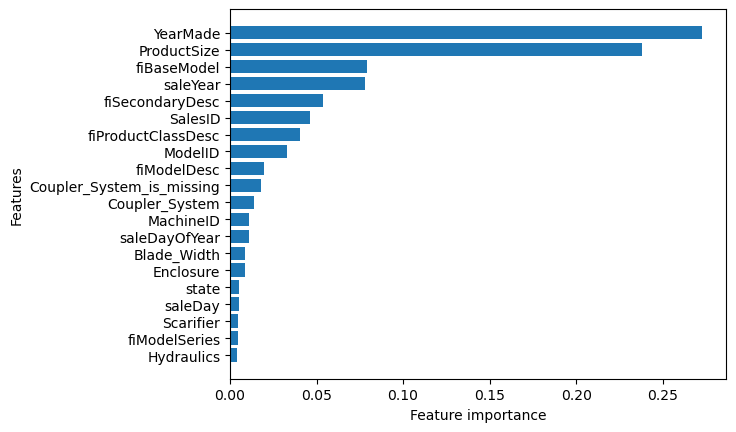

In [90]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [92]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [94]:
df["ProductSize"].value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

We see that the top two features, `YearMade` and `ProductSize`, have been identified to play a more considerable influence in the `SalePrice` as compared to the remaining 18 features.